# Medical Image Classification 🫁 - Bastian Wittmann

In this exercise, we will use the Python deep learning library [**PyTorch**](https://pytorch.org/) to build and experiment with basic neural networks.

In the first part of this notebook, you will find a step-by-step example of the classic machine learning problem of image classification. We will start with a simple linear network. In the second part, we will move to Convolutional Neural Networks, including the prominent ResNet architecture.

These introductory problems are intentionally kept brief and rather simple. The main goal of this session is for you to get an idea of how to tackle machine learning problems and develop a good workflow that can easily be adapted for other, more elaborate problems.

In [1]:
%%capture
# First, we need import some important libraries and check for gpu availability
import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms as Transforms
import copy
import os

torch.manual_seed(0)  # for reproducability of results
gpu_available = torch.cuda.is_available()

In [2]:
print('GPU available in your runtime:', gpu_available)

GPU available in your runtime: True


## 0) Introduction to PyTorch's `torch.tensor`

[**Tensors**](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) are the central data abstraction in PyTorch and typically used to present images, time series, and other input modalities. In the following, we introduce the most important functions and features corresponding to the `torch.tensor` utilized to check its shape, data type, and the current device it resides on.

In [3]:
tensor1 = torch.tensor([[1, 1, 1], [2, 2, 2]])    # we init a 2d tensor with 2 rows and 3 columns
print('tensor1:\n', tensor1, '\n')
print('tensor1.shape:\n', tensor1.shape, '\n')
print('tensor1.dtype:\n', tensor1.dtype, '\n')    # the tensor is of the torch.int64 dtype
print('tensor1.device:\n', tensor1.device, '\n')  # the tensor resides currently on the cpu

tensor2 = torch.tensor([[0, 0, 1], [0, 0, 1]])    # we init a second 2d tensor of the same shape
print('tensor2:\n', tensor2, '\n')

tensor1:
 tensor([[1, 1, 1],
        [2, 2, 2]]) 

tensor1.shape:
 torch.Size([2, 3]) 

tensor1.dtype:
 torch.int64 

tensor1.device:
 cpu 

tensor2:
 tensor([[0, 0, 1],
        [0, 0, 1]]) 



Arithmetic operations between tensors and scalars, such as addition, subtraction, multiplication, division, and exponentiation are distributed over every element of the tensor. Similar operations between two tensors also behave as you would intuitively expect.

In [4]:
tensor3 = tensor1 - 1
tensor4 = tensor1 * 100
print('tensor4:\n', tensor4, '\n')

tensor5 = tensor1 - tensor2
tensor6 = tensor1 + tensor2
tensor7 = tensor1 / tensor2
tensor8 = tensor1 * tensor2
print('tensor8:\n', tensor8, '\n')

tensor4:
 tensor([[100, 100, 100],
        [200, 200, 200]]) 

tensor8:
 tensor([[0, 0, 1],
        [0, 0, 2]]) 



Importantly, the shape of tensors can be modified very easily. The code block below introduces the three most important operations required to adjust the shape of tensors to the task at hand.

In [5]:
tensor9 = tensor1.flatten()                     # we flatten the tensor
print('tensor9:\n', tensor9, '\n')
print('tensor9.shape:\n', tensor9.shape, '\n')

tensor10 = tensor1.reshape(3, 2)                # we reshape the tensor
print('tensor10:\n', tensor10, '\n')
print('tensor10.shape:\n', tensor10.shape, '\n')

tensor11 = tensor1.unsqueeze(0)                 # we add an additional dimension at position 0
print('tensor11:\n', tensor11, '\n')
print('tensor11.shape:\n', tensor11.shape, '\n')

tensor9:
 tensor([1, 1, 1, 2, 2, 2]) 

tensor9.shape:
 torch.Size([6]) 

tensor10:
 tensor([[1, 1],
        [1, 2],
        [2, 2]]) 

tensor10.shape:
 torch.Size([3, 2]) 

tensor11:
 tensor([[[1, 1, 1],
         [2, 2, 2]]]) 

tensor11.shape:
 torch.Size([1, 2, 3]) 



We can also change a tensor's data type and the device it resides on using `Tensor.to`. Please note that google colab sometimes fails to provide GPUs due to the limited availability of resources.

In [11]:
if gpu_available:
  tensor1 = tensor1.to(dtype=torch.float64, device='cuda')
tensor1.dtype, tensor1.device

(torch.float64, device(type='cuda', index=0))

In this specific example, we changed the dtype of tensor1 to `float64` and the device to `cuda`, a GPU (we typically do this for fast computation).

We can also create tensors of a specific shape by using some of PyTorch's [**creation ops**](https://pytorch.org/docs/stable/torch.html#creation-ops). Please take a look at the linked docs.

❗TASK❗: Can you create a tensor of the shape `[1, 3, 100, 100]` filled with random numbers from a uniform distribution? Please replace `None` with the corresponding expression. Feel free to take some minutes to play around with the `torch.tensor` data structure to familiarize yourself with PyTorch's basic building blocks. This is essential for other tasks in this notebook.

In [12]:
tensor12 = torch.ones((4, 3, 224, 224))
print('tensor12.shape:\n', tensor12.shape, '\n')
print(tensor12.min().item(), tensor12.max().item())  # we created a tensor consisting solely of ones

tensor13 = torch.rand((1, 3, 100, 100))

tensor12.shape:
 torch.Size([4, 3, 224, 224]) 

1.0 1.0


## 1) Preparing the Data

In this section, we aim to prepare a dataset for the task of image classification. To this end, we first need to download the data from the internet. Please make sure to use the small version of the dataset for now.

In [13]:
# Switch between small and large version of the dataset
!curl -l -o small_dataset.zip "https://filesender.switch.ch/filesender2/download.php?token=6ef22360-c2b4-4f6f-824d-bba07ebfac6f&files_ids=482780"
# !curl -l -o full_dataset.zip "https://filesender.switch.ch/filesender2/download.php?token=e287a5d0-2729-43a0-b504-c63e8da16433&files_ids=482778"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1169M  100 1169M    0     0  20.9M      0  0:00:55  0:00:55 --:--:-- 23.3M


In [14]:
%%capture
! unzip -o small_dataset.zip
#! unzip -o full_dataset.zip

PyTorch allows us to create datasets for images in an efficient way using the [**datasets.ImageFolder**](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) class. The class can also take [**Transforms**](https://pytorch.org/vision/stable/transforms.html) from torchvision, which is the library PyTorch uses for processing images. These transformations can contain data preprocessing, like resizing, cropping, normalization, or data augmentations.

First, we create transforms for the training, validation, and test set. Typically, the test and validation transforms are the same, while data augmentation techniques are mostly solely applied to the training set.

❗TAKS❗: Please replace `None` with the necessary transformation for testing and hence validation. The transform should be comprised of three building blocks: First, we aim to resize the image to the same size used for training; second, we want to transform the image to a `torch.tensor`; and third, images should be normalized. Feel free to get inspirations from `train_transforms`.

In [15]:
def data_transforms():
    train_transforms = Transforms.Compose([
            Transforms.Resize(size = (256, 256)),
            Transforms.RandomRotation(degrees = (-20,+20)),
            Transforms.CenterCrop(size=224),
            Transforms.ToTensor(),
            Transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

    test_transforms = Transforms.Compose([
                Transforms.Resize(size = (224,224)),
                Transforms.ToTensor(),
                Transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])

    val_transforms = copy.deepcopy(test_transforms)
    return train_transforms, val_transforms, test_transforms

# create train, val, and test transform
train_transforms, val_transforms, test_transforms = data_transforms()

We use the created transforms to initialize our train, test, and validation set.



In [16]:
print('Files in content:', os.listdir())
data_dir = os.path.join(os.getcwd()) #, 'chest_xray')

TEST = 'test'
TRAIN = 'train'
VAL ='val'

# initialize train, val, and test set
trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN), transform = train_transforms)
testset = datasets.ImageFolder(os.path.join(data_dir, TEST), transform = val_transforms)
validset = datasets.ImageFolder(os.path.join(data_dir, VAL), transform = test_transforms)

# check how many images are contained in the respective sets
print('Images in trainset:', len(trainset))
print('Images in testset:', len(testset))
print('Images in validset:', len(validset))

Files in content: ['.config', 'test', 'train', 'val', 'small_dataset.zip', 'sample_data']
Images in trainset: 5216
Images in testset: 624
Images in validset: 16


In [17]:
# play a bit with the ImageFolder dataset class
print(trainset, '\n')               # display relevant information of training set including transforms
print(trainset.classes, '\n')       # present classes in our dataset
print(trainset.class_to_idx, '\n')  # corresponding class IDs

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /content/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 

['NORMAL', 'PNEUMONIA'] 

{'NORMAL': 0, 'PNEUMONIA': 1} 



We will use stochastic gradient descent (SGD)  for learning the model parameters. So, we would load a mini-batch of data. We have set the value as four by default.

In [18]:
batch_size = 4

Next, we have to create dataloaders, which provide efficient iterables to sample images from our dataset. We would like to create one dataloader for each of the data splits. For the training data, the `shuffle` parameter should be set to `True`, while for validation and test dataloaders, `shuffle` should be `False`. You have to use the [**DataLoader**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class for this task.

❗TASK❗: Please initialize the `trainloader`, the `valloader`, and the `testloader`. You have to use the [**DataLoader**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class for this task. Please just specify the `dataset`, the `batch_size`, and the `shuffle` parameters.

In [19]:
# create dataloaders from datasets
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle = True)
valloader = DataLoader(validset, batch_size=batch_size, shuffle = False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle = False)

# retrieve on data batch from trainset via trainloader
images, labels = next(iter(trainloader))
images_test, labels_test = next(iter(testloader))
assert images.shape == images_test.shape, 'Please check if you initialized the test_transforms correctly'
assert images.shape[0] == batch_size, 'The dataloader seems to not work correctly'

print(images.shape, '\n')               # a batch obtained from the dataloader consists of 4 images with the size of 224x224 and 3 channels
print(labels.shape, '\n')               # we have for each image in the batch exactly one label
print(trainset.class_to_idx, labels)

torch.Size([4, 3, 224, 224]) 

torch.Size([4]) 

{'NORMAL': 0, 'PNEUMONIA': 1} tensor([0, 1, 0, 1])


In [20]:
# let us create an additional, swaped helper dictionary to make our lives easier
idx_to_class = {value:key for key, value in trainset.class_to_idx.items()}
print(idx_to_class)

{0: 'NORMAL', 1: 'PNEUMONIA'}


It is always a smart idea to visualize an image from the training set as a sanity check.
Please note that your introduced transforms are already applied here.

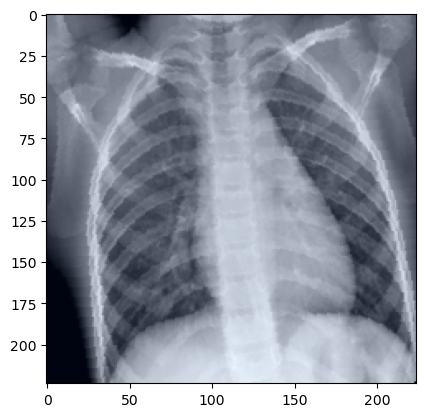

GroundTruth:  N O R M A L


In [21]:
idx_choice = 0  # we visualize the first image in our batch
img, label = images[idx_choice], labels[idx_choice].item()

def imshow(img):
    img = (img - img.min())/ (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images and print the label
imshow(img)
print('GroundTruth: ', ' '.join(f'{idx_to_class[label]:5s}'))

## 2) Model 1 - Fully Connected Network (FCN/MLP)

Let's look at a fully worked-through example of a neural network built in PyTorch. The problem we will solve is a machine learning classic: Image classification. We will be using the above-prepared chest x-ray dataset for this purpose.

First, let's define the problem: We are trying to solve the classification of chest x-ray images with **2** different possible classes (NORMAL & PNEUMONIA). We have transformed the images into three channels (necessary for pre-trained ResNet in section 4). Each channel consists of values between 0-255. We want to develop models that can process these images to recognize the category they represent.

Since we will start with Fully Connected Networks, we have to convert the image into a single vector. We will do so using the `reshape` function from PyTorch. This is necessary as the Fully Connected Networks processes vectors representative of an image's content rather than 2d images.

Remember that the gradient decent optimizer operates on mini-batches for training our models. So, we would always load a mini-batch of samples and process them together.

In [22]:
mini_batch_images, mini_batch_labels = next(iter(trainloader))
print(mini_batch_images.shape, '\n')

# reshape image to vector
print(mini_batch_images.reshape(batch_size, 3 * 224 * 224).shape)

# we can also make use of the PyTorch library to make things a bit simpler
print(mini_batch_images.reshape(batch_size, -1).shape)
print(mini_batch_images.reshape(-1, 3 * 224 * 224).shape)

# the dimension of the flattened image / vector is therefore
input_dim = mini_batch_images.reshape(batch_size, -1).shape[-1]

torch.Size([4, 3, 224, 224]) 

torch.Size([4, 150528])
torch.Size([4, 150528])
torch.Size([4, 150528])


Our network will receive a single vector of **150528** dimensions and return a vector of **2** (number of classes we want to predict) dimensions. The output should correspond to how likely the vector represents a specific class with a larger value indicating a high probability.

### Building the Fully Connected Network

We want our network to have three linear layers. The last layer should have `out_features = num_classes`. Remember that you also need a non-linearity (do you remember why?). You can use `F.relu()` for the non-linearity.

PyTorch models are defined as classes with the parent class `nn.Module()`. They initialize the layers in the `__init__` method and they need to have a `forward()` method in which an input tensor is processed. This function is later called implicitly by PyTorch during optimization.

Use the [**Linear**](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) class from PyTorch to create the linear layers.
* `lin1` should have out_features = input_dim/256
* `lin2` should have in_features = input_dim/256, out_features = input_dim/1024
* `lin3` should have out_features = num_classes

Remember that the `in_channel` and `out_channel` should be **integers**

❗TASK❗: Replace `None` by initializing the three linear layers appropriately. Please just specify the parameters `in_features` and `out_features`.

In [23]:
class FCNetwork(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, input_dim//256)
        self.lin2 = nn.Linear(input_dim//256, input_dim//1024)
        self.lin3 = nn.Linear(input_dim//1024, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)     # apply ReLU
        x = self.lin2(x)
        x = F.relu(x)     # apply ReLU
        x = self.lin3(x)
        return x

In [25]:
# we now initialize an instance of our FCNetwork class
network = FCNetwork(input_dim=input_dim, num_classes=2)
network

FCNetwork(
  (lin1): Linear(in_features=150528, out_features=588, bias=True)
  (lin2): Linear(in_features=588, out_features=147, bias=True)
  (lin3): Linear(in_features=147, out_features=2, bias=True)
)

### Creating the optimizer and the loss function
We will use [**CrossEntropy**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the loss function and [**SGD**](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) as the optimizer.

Use a learning rate of `0.001` and set the `momentum` parameter to `0.9`.

In [26]:
criterion = nn.CrossEntropyLoss() # our loss function
optimizer = torch.optim.SGD(network.parameters(), lr=1e-3, momentum=0.9)

In [27]:
PATH = './linear_net.pth'   # path to store trained model parameters

In [28]:
# for fast computation, we aim to use a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)  # let us put our model parameters on the device

if gpu_available:
  print(torch.cuda.get_device_name(device))
device

Tesla T4


device(type='cuda')

### Training the model
The following code trains the network for two epochs. Please note that epochs stop earlier (after 200 iterations) if you did not obtain a GPU in your runtime. Otherwise, computation will take up too much time in our practical session. This will, unfortunately, result in slightly worse predictions.

❗TAKS❗: Please familiarize yourself with this simple train loop. The structure is typically the same for many applications. Remember that our `network` operates on vectors rather than images. Therefore, please reshape the `input` to our network appropriately by replacing `None`. Hint: You have already learned how to do this.

In [29]:
min_val_loss = float("inf")  # initialize best loss to infinity
for epoch in range(2):       # loop over the dataset multiple times (= epochs)
    print('\n', f'Start epoch {epoch + 1}')

    ### TRAINING ###
    running_loss = 0.0  # variable to accumulate the loss across mini-batches
    network.train()     # set model to training mode for gradient accumulation (often forgotten and leads to bugs!)
    for i, data in enumerate(tqdm(trainloader, f'Train epoch {epoch + 1}', mininterval=1)):  # loop through the mini-batches
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # both the model and the data need to be on the same device

        # zero the parameter gradients
        optimizer.zero_grad()

        # reshape the inputs
        inputs = inputs.reshape(-1, 3*224*224)

        outputs = network(inputs)          # perform inference
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()                    # compute gradients
        optimizer.step()                   # optimizer updates weights using gradients

        # print training loss
        running_loss += loss.item()
        if i % 100 == 99 :    # every 100 mini-batches
            print('\n', f'[Epoch {epoch + 1}, iteration {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

        if not gpu_available and i == 200:
          break

    ### VALIDATION ###
    network.eval()  # set to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(tqdm(valloader, 'Validation')):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # both the model and the data need to be on the same device

            # reshape the inputs
            inputs = inputs.reshape(-1, 3*224*224)

            outputs = network(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # print val loss
        print('\n', f'Epoch {epoch + 1} validation loss: {val_loss / len(valloader):.3f}')

    if val_loss < min_val_loss: # save the network parameters based on smallest val loss
        min_val_loss = val_loss
        print(f"The new best model is at epoch {epoch + 1} with validation loss of {val_loss / len(valloader):.3f}")
        torch.save(network.state_dict(), PATH)



 Start epoch 1


Train epoch 1:   7%|▋         | 94/1304 [00:10<01:38, 12.24it/s]


 [Epoch 1, iteration   100] loss: 0.385


Train epoch 1:  15%|█▌        | 199/1304 [00:19<01:35, 11.58it/s]


 [Epoch 1, iteration   200] loss: 0.350


Train epoch 1:  23%|██▎       | 296/1304 [00:27<01:32, 10.85it/s]


 [Epoch 1, iteration   300] loss: 0.216


Train epoch 1:  30%|██▉       | 388/1304 [00:35<01:14, 12.23it/s]


 [Epoch 1, iteration   400] loss: 0.230


Train epoch 1:  38%|███▊      | 493/1304 [00:44<01:08, 11.88it/s]


 [Epoch 1, iteration   500] loss: 0.251


Train epoch 1:  45%|████▌     | 591/1304 [00:53<01:18,  9.05it/s]


 [Epoch 1, iteration   600] loss: 0.252


Train epoch 1:  53%|█████▎    | 696/1304 [01:02<00:49, 12.18it/s]


 [Epoch 1, iteration   700] loss: 0.281


Train epoch 1:  61%|██████▏   | 799/1304 [01:11<00:41, 12.04it/s]


 [Epoch 1, iteration   800] loss: 0.270


Train epoch 1:  69%|██████▉   | 897/1304 [01:19<00:38, 10.61it/s]


 [Epoch 1, iteration   900] loss: 0.182


Train epoch 1:  76%|███████▌  | 990/1304 [01:27<00:25, 12.43it/s]


 [Epoch 1, iteration  1000] loss: 0.237


Train epoch 1:  84%|████████▍ | 1097/1304 [01:36<00:17, 11.99it/s]


 [Epoch 1, iteration  1100] loss: 0.210


Train epoch 1:  92%|█████████▏| 1194/1304 [01:45<00:10, 10.23it/s]


 [Epoch 1, iteration  1200] loss: 0.227


Train epoch 1: 100%|█████████▉| 1302/1304 [01:54<00:00, 12.94it/s]


 [Epoch 1, iteration  1300] loss: 0.231


Validation: 100%|██████████| 4/4 [00:00<00:00, 16.40it/s]



 Epoch 1 validation loss: 1.129
The new best model is at epoch 1 with validation loss of 1.129

 Start epoch 2


Train epoch 2:   7%|▋         | 92/1304 [00:07<01:34, 12.85it/s]


 [Epoch 2, iteration   100] loss: 0.197


Train epoch 2:  15%|█▍        | 195/1304 [00:16<01:29, 12.38it/s]


 [Epoch 2, iteration   200] loss: 0.213


Train epoch 2:  23%|██▎       | 300/1304 [00:25<01:27, 11.54it/s]


 [Epoch 2, iteration   300] loss: 0.169


Train epoch 2:  30%|███       | 392/1304 [00:33<01:20, 11.27it/s]


 [Epoch 2, iteration   400] loss: 0.237


Train epoch 2:  38%|███▊      | 500/1304 [00:42<01:00, 13.26it/s]


 [Epoch 2, iteration   500] loss: 0.183


Train epoch 2:  45%|████▌     | 593/1304 [00:50<01:00, 11.77it/s]


 [Epoch 2, iteration   600] loss: 0.175


Train epoch 2:  54%|█████▎    | 700/1304 [00:59<00:57, 10.48it/s]


 [Epoch 2, iteration   700] loss: 0.186


Train epoch 2:  61%|██████    | 791/1304 [01:07<00:41, 12.36it/s]


 [Epoch 2, iteration   800] loss: 0.171


Train epoch 2:  69%|██████▊   | 896/1304 [01:16<00:33, 12.10it/s]


 [Epoch 2, iteration   900] loss: 0.195


Train epoch 2:  77%|███████▋  | 1000/1304 [01:26<00:30, 10.07it/s]


 [Epoch 2, iteration  1000] loss: 0.247


Train epoch 2:  84%|████████▍ | 1095/1304 [01:33<00:16, 12.41it/s]


 [Epoch 2, iteration  1100] loss: 0.151


Train epoch 2:  92%|█████████▏| 1199/1304 [01:42<00:08, 12.20it/s]


 [Epoch 2, iteration  1200] loss: 0.182


Train epoch 2:  99%|█████████▉| 1293/1304 [01:50<00:00, 11.08it/s]


 [Epoch 2, iteration  1300] loss: 0.126


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.48it/s]


 Epoch 2 validation loss: 2.446


### Inference
The following code shows the twenty-fifth image from the test set:

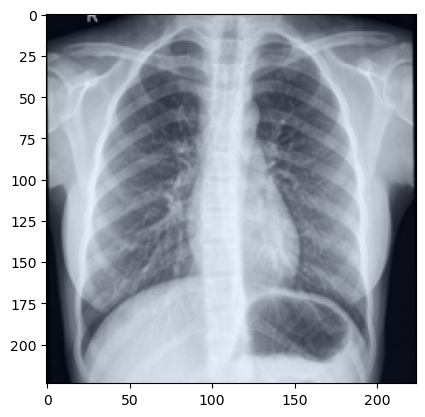

GroundTruth:  N O R M A L


In [30]:
test_image, test_label = testset[24]

# show image and print the label
imshow(test_image)
print('GroundTruth: ', ' '.join(f'{idx_to_class[test_label]}' ))

Let's load the trained model so we can use it to perform inference on the test set:

In [31]:
network = FCNetwork(input_dim=input_dim, num_classes=2)
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Let's see how the trained model works on one sample. Remember, our model still works with mini-batches. So, when we say one sample, it implies `batch_size=1`. However, it does not look right to create the dataloader once again, especially when we want to use it for a quick test. Luckily, we can use the `unsqueeze()` function here.

In [32]:
test_image.shape

torch.Size([3, 224, 224])

In [33]:
test_image_with_batch = test_image.unsqueeze(0)
test_image_with_batch.shape

torch.Size([1, 3, 224, 224])

In [34]:
test_image_with_batch_reshaped = test_image_with_batch.reshape(-1, 3*224*224)
outputs = network(test_image_with_batch_reshaped)  # this calls the models foward method implicitely

In [35]:
print(outputs.shape, outputs)

torch.Size([1, 2]) tensor([[-0.5452,  0.6976]], grad_fn=<AddmmBackward0>)


In [37]:
_, predicted = torch.max(outputs, 1, keepdim=True)
print(f"Actual labels: {idx_to_class[test_label]}")
print('Predicted: ', ' '.join(f'{idx_to_class[predicted.item()]}'))


Actual labels: NORMAL
Predicted:  P N E U M O N I A


Did the model predict the correct class? If so, good job!

### Evaluation
Next, we evaluate the trained model's performance on the `test` set. We will use `accuracy` as the evaluation metric. The higher the accuracy, the better the performance of your trained model.

❗OPTIONAL TASK❗: Try to increase the model's performance on the test set! To do so, play around with the model parameters. E.g., maybe an additional linear layer, a different non-linearity, or more extensive data augmentation techniques help to obtain better results. One could also train the model for more epochs or experiment with the large version of the dataset. Other parameters worth investigating are the learning rate, the batch size, and the size of the validation set. You hopefully noticed that the validation loss is currently calculated based on the classifier's predictions of solely 16 images. Please consider that under no circumstances should the test set be used for model training.

In [38]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
network.to(device)
network.eval()
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # calculate outputs by running images through the network
        images = images.reshape(-1, 3 * 224 * 224)
        outputs = network(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('\n', f'Accuracy of the network on the test images: {100 * correct / total} %')

100%|██████████| 156/156 [00:10<00:00, 15.08it/s]


 Accuracy of the network on the test images: 81.73076923076923 %


## 3) Model 2 - Simple Convolutional Neural Network (CNN)

Convolutional Neural Networks (CNNs) have become the de-facto standard in image processing tasks and will, therefore, hopefully achieve better results on the test set. We would first explore a simple CNN and then move to one of the most popular architectures, ResNet.

The simple Convolutional Neural Network you will create in this section should have **two** convolutional layers followed by **two** linear layers. Refer to PyTorch documentation and the previous example for additional help. The last `linear` layer should have `out_features = num_classes`.

All the processing happens in the `forward()` function. Remember that you also need a non-linearity (why?). You can use `F.relu()` as a non-linearity.
Use the [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) class from PyTorch for linear layers and [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for the convolutional layers.

* `conv1` should have in_channels = 3 (why?) and out_channels = 10, kernel_size should be 5.
* `conv2` should have in_channels = 10 and out_channels = 20, kernel_size should be 5.
* `conv2_drop`: Create a dropout layer. Use [Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html) for this task.  
* `max_pool1`, `max_pool2`: Create two max-pooling layers with kernel size 4. You have to use [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) class for this task.
* Flatten the input so that it can be processed by the linear layers
* `fc1` should have in_features=2880 (why?), out_features = 50.
* `fc2` should have out_features = num_classes.

Remember that the `in_channel` and `out_channel` should be **integers**.

❗Task❗: Initialize the convolutional layers, the dropout layer, the max-pooling layers, and the two fully connected layers based on the specifications above. Replace `None` with appropriate statements.

In [39]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super(CNNNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.max_pool1 = nn.MaxPool2d(kernel_size=4)
        self.max_pool2 = nn.MaxPool2d(kernel_size=4)
        self.fc1 = nn.Linear(in_features=2880, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = F.relu(x)
        x = self.conv2_drop(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = F.relu(x)
        x = x.view(-1, 2880)  # now we flatten the input
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [40]:
cnn_network = CNNNetwork()
cnn_network.to(device)    # put the model's parameters to our device

CNNNetwork(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (max_pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (max_pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2880, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Create an optimizer and the loss function for the `cnn_network`. We will use [**CrossEntropy**](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the loss function and [**SGD**](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) as the optimizer, similar to last time. Use a learning rate of `0.001` and set the `momentum` parameter to `0.9`.

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_network.parameters(), lr=0.001, momentum=0.9)

In [42]:
PATH = './cnn_net.pth'

Now, we train our CNN model by calling the `train_cnn_network` function.
Please note that the training loop defined in `train_cnn_network` is almost identical to the Fully Connected Network's training loop. Can you identify the difference between the two training loops? Since the CNN trains significantly faster compared to the Fully Connected Network, we do not restrict iterations per epoch when no GPU is available.

In [43]:
def train_cnn_network(cnn_network, train_dataloader, val_dataloader, optimizer, criterion, break_itera=float("inf")):
    min_val_loss = float("inf")
    for epoch in range(2):
        print('\n', f'Start epoch {epoch + 1}')

        ### TRAINING ###
        running_loss = 0.0
        cnn_network.train()
        for i, data in enumerate(tqdm(train_dataloader, f'Train epoch {epoch + 1}', mininterval=1)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = cnn_network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print training loss
            running_loss += loss.item()
            if i % 100 == 99 :
                print('\n', f'[Epoch {epoch + 1}, iteration {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

            if not gpu_available and i == break_itera:
                break

        ### VALIDATION ###
        network.eval()
        val_loss = 0
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_dataloader, 'Validation')):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = cnn_network(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

            # print val loss
            print('\n', f'Epoch {epoch + 1} validation loss: {val_loss / len(val_dataloader):.3f}')

        if val_loss < min_val_loss: # save the network parameters based on smallest val loss
            min_val_loss = val_loss
            print(f"The new best model is at epoch {epoch + 1} with validation loss of {val_loss / len(val_dataloader):.3f}")
            torch.save(cnn_network.state_dict(), PATH)

In [44]:
train_cnn_network(
    cnn_network=cnn_network, train_dataloader=trainloader, val_dataloader=valloader,
    optimizer=optimizer, criterion=criterion
)


 Start epoch 1


Train epoch 1:   7%|▋         | 94/1304 [00:11<01:50, 10.91it/s]


 [Epoch 1, iteration   100] loss: 0.941


Train epoch 1:  15%|█▍        | 192/1304 [00:17<01:14, 14.94it/s]


 [Epoch 1, iteration   200] loss: 0.561


Train epoch 1:  22%|██▏       | 289/1304 [00:24<01:19, 12.73it/s]


 [Epoch 1, iteration   300] loss: 0.422


Train epoch 1:  31%|███       | 400/1304 [00:32<01:09, 13.09it/s]


 [Epoch 1, iteration   400] loss: 0.357


Train epoch 1:  38%|███▊      | 500/1304 [00:40<00:58, 13.85it/s]


 [Epoch 1, iteration   500] loss: 0.322


Train epoch 1:  46%|████▌     | 597/1304 [00:46<00:45, 15.68it/s]


 [Epoch 1, iteration   600] loss: 0.231


Train epoch 1:  53%|█████▎    | 693/1304 [00:54<00:41, 14.90it/s]


 [Epoch 1, iteration   700] loss: 0.280


Train epoch 1:  61%|██████    | 792/1304 [01:00<00:36, 13.94it/s]


 [Epoch 1, iteration   800] loss: 0.308


Train epoch 1:  69%|██████▉   | 903/1304 [01:08<00:26, 14.98it/s]


 [Epoch 1, iteration   900] loss: 0.251


Train epoch 1:  77%|███████▋  | 1002/1304 [01:15<00:23, 13.12it/s]


 [Epoch 1, iteration  1000] loss: 0.277


Train epoch 1:  84%|████████▍ | 1099/1304 [01:21<00:13, 15.49it/s]


 [Epoch 1, iteration  1100] loss: 0.275


Train epoch 1:  92%|█████████▏| 1195/1304 [01:28<00:07, 14.27it/s]


 [Epoch 1, iteration  1200] loss: 0.241


Train epoch 1:  99%|█████████▉| 1294/1304 [01:35<00:00, 14.95it/s]


 [Epoch 1, iteration  1300] loss: 0.264


Validation: 100%|██████████| 4/4 [00:00<00:00, 17.25it/s]



 Epoch 1 validation loss: 1.465
The new best model is at epoch 1 with validation loss of 1.465

 Start epoch 2


Train epoch 2:   8%|▊         | 99/1304 [00:07<01:21, 14.74it/s]


 [Epoch 2, iteration   100] loss: 0.247


Train epoch 2:  15%|█▌        | 198/1304 [00:13<01:09, 15.80it/s]


 [Epoch 2, iteration   200] loss: 0.215


Train epoch 2:  23%|██▎       | 296/1304 [00:20<01:06, 15.27it/s]


 [Epoch 2, iteration   300] loss: 0.258


Train epoch 2:  31%|███       | 400/1304 [00:27<01:07, 13.31it/s]


 [Epoch 2, iteration   400] loss: 0.247


Train epoch 2:  38%|███▊      | 496/1304 [00:34<00:53, 15.03it/s]


 [Epoch 2, iteration   500] loss: 0.232


Train epoch 2:  45%|████▌     | 592/1304 [00:41<00:56, 12.50it/s]


 [Epoch 2, iteration   600] loss: 0.216


Train epoch 2:  54%|█████▎    | 698/1304 [00:47<00:38, 15.74it/s]


 [Epoch 2, iteration   700] loss: 0.184


Train epoch 2:  61%|██████▏   | 799/1304 [00:55<00:36, 13.70it/s]


 [Epoch 2, iteration   800] loss: 0.245


Train epoch 2:  69%|██████▉   | 900/1304 [01:01<00:25, 15.55it/s]


 [Epoch 2, iteration   900] loss: 0.206


Train epoch 2:  77%|███████▋  | 998/1304 [01:08<00:21, 14.35it/s]


 [Epoch 2, iteration  1000] loss: 0.170


Train epoch 2:  84%|████████▍ | 1097/1304 [01:14<00:13, 15.37it/s]


 [Epoch 2, iteration  1100] loss: 0.196


Train epoch 2:  91%|█████████▏| 1191/1304 [01:21<00:08, 13.99it/s]


 [Epoch 2, iteration  1200] loss: 0.266


Train epoch 2:  99%|█████████▉| 1288/1304 [01:28<00:01, 15.11it/s]


 [Epoch 2, iteration  1300] loss: 0.174


Validation: 100%|██████████| 4/4 [00:00<00:00,  9.54it/s]


 Epoch 2 validation loss: 1.378
The new best model is at epoch 2 with validation loss of 1.378


Let us now load the best model parameters corresponding to our CNN that were saved during training. We, as always, subsequently move our network to the device.

In [45]:
cnn_network = CNNNetwork()
cnn_network.load_state_dict(torch.load(PATH))
cnn_network.to(device)

CNNNetwork(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (max_pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (max_pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2880, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Again, we evaluate the performance of our model on the test set using the `evaluate_cnn_model` function. Can you achieve better performances compared to the Fully Connected Network? Do you recall why this might be the case?

In [46]:
def evaluate_cnn_model(cnn_network, test_loader):
    correct = 0
    total = 0
    cnn_network.eval()
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = cnn_network(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('\n', f'Accuracy of the network on the test images: {100 * correct / total} %')

❗OPTIONAL TASK❗: Try to increase the model's performance on the test set! For inspiration, please refer to the optional task in section 2. Try to also explore [**`nn.Conv2d`'s parameters**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), such as `kernel_size`, `stride`, and `dilation`.





In [47]:
evaluate_cnn_model(cnn_network=cnn_network, test_loader=testloader)

100%|██████████| 156/156 [00:10<00:00, 15.31it/s]


 Accuracy of the network on the test images: 85.57692307692308 %


## 4) Model 3 - Deep Residual Network (ResNet)

Finally, let's train a [**ResNet model**](https://arxiv.org/abs/1512.03385). Please look at page four of the linked paper or the corresponding slide in our presentation to get an overview of the ResNet model's architecture. So, let's code our own implementation of the ResNet model. Just kidding 😀.

Fortunately, we can use PyTorch to simply import the ResNet model in our notebook. By doing so, we save lots of time. As a bonus, we can also use the pre-trained weights from ImageNet (a huge collection of annotated images). It has been observed that such pretrained weights often result in drastically increased performances when the actual training data is limited, which is typically the case in medical image analysis.

In [48]:
from torchvision.models import resnet34
resnet_model = resnet34(weights="IMAGENET1K_V1")  # we specify the use of pretrained weights
resnet_model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 312MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Did you notice the significant increase in trainable layers compared to our simple models from the previous sections?

We need to change ResNet's final layer to suit our downstream task. The original model has been trained to predict 1000 classes, while our task requires just two.

In [49]:
%%capture
in_features_to_resnet_fc = resnet_model.fc.in_features  # we adopt earlier resnet blocks
resnet_model.fc = nn.Linear(in_features=in_features_to_resnet_fc, out_features=2) # we add a linear layer with an output dimension of 2
resnet_model.to(device)

We use the same optimizer, criterion, and train loop as in the previous experiment with the simple CNN.

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

In [51]:
PATH = './resnet34.pth'

Now, we train the ResNet model by calling the `train_cnn_network` function, similar to section 3. The training loop does not need any modifications, as ResNet boils down to a more complex Convolutional Neural Network.
Since ResNet trains quite slow on a CPU, we restrict iterations per epoch when no GPU is available to 100 for demonstration purposes. Please feel free to remove this restriction when you are in time by modifying `break_itera`.

In [52]:
train_cnn_network(
    cnn_network=resnet_model, train_dataloader=trainloader, val_dataloader=valloader,
    optimizer=optimizer, criterion=criterion, break_itera=100
)


 Start epoch 1


Train epoch 1:   7%|▋         | 95/1304 [00:10<02:05,  9.63it/s]


 [Epoch 1, iteration   100] loss: 0.422


Train epoch 1:  15%|█▍        | 191/1304 [00:19<01:48, 10.22it/s]


 [Epoch 1, iteration   200] loss: 0.236


Train epoch 1:  22%|██▏       | 293/1304 [00:28<01:33, 10.79it/s]


 [Epoch 1, iteration   300] loss: 0.231


Train epoch 1:  30%|███       | 394/1304 [00:38<01:25, 10.65it/s]


 [Epoch 1, iteration   400] loss: 0.259


Train epoch 1:  38%|███▊      | 497/1304 [00:49<01:17, 10.36it/s]


 [Epoch 1, iteration   500] loss: 0.293


Train epoch 1:  46%|████▌     | 597/1304 [00:59<01:13,  9.61it/s]


 [Epoch 1, iteration   600] loss: 0.202


Train epoch 1:  53%|█████▎    | 692/1304 [01:07<00:55, 10.97it/s]


 [Epoch 1, iteration   700] loss: 0.190


Train epoch 1:  61%|██████    | 796/1304 [01:18<00:43, 11.55it/s]


 [Epoch 1, iteration   800] loss: 0.144


Train epoch 1:  69%|██████▉   | 902/1304 [01:28<00:36, 11.09it/s]


 [Epoch 1, iteration   900] loss: 0.159


Train epoch 1:  76%|███████▌  | 991/1304 [01:37<00:32,  9.72it/s]


 [Epoch 1, iteration  1000] loss: 0.254


Train epoch 1:  84%|████████▍ | 1100/1304 [01:47<00:20, 10.03it/s]


 [Epoch 1, iteration  1100] loss: 0.168


Train epoch 1:  92%|█████████▏| 1195/1304 [01:55<00:09, 11.32it/s]


 [Epoch 1, iteration  1200] loss: 0.085


Train epoch 1: 100%|█████████▉| 1299/1304 [02:05<00:00, 10.87it/s]


 [Epoch 1, iteration  1300] loss: 0.182


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.40it/s]



 Epoch 1 validation loss: 2.735
The new best model is at epoch 1 with validation loss of 2.735

 Start epoch 2


Train epoch 2:   7%|▋         | 95/1304 [00:09<01:55, 10.49it/s]


 [Epoch 2, iteration   100] loss: 0.173


Train epoch 2:  15%|█▌        | 198/1304 [00:19<01:53,  9.78it/s]


 [Epoch 2, iteration   200] loss: 0.088


Train epoch 2:  23%|██▎       | 294/1304 [00:27<01:32, 10.93it/s]


 [Epoch 2, iteration   300] loss: 0.080


Train epoch 2:  30%|██▉       | 391/1304 [00:37<01:26, 10.57it/s]


 [Epoch 2, iteration   400] loss: 0.076


Train epoch 2:  38%|███▊      | 497/1304 [00:48<01:14, 10.81it/s]


 [Epoch 2, iteration   500] loss: 0.103


Train epoch 2:  45%|████▌     | 592/1304 [00:57<01:11, 10.00it/s]


 [Epoch 2, iteration   600] loss: 0.099


Train epoch 2:  54%|█████▎    | 698/1304 [01:06<00:54, 11.11it/s]


 [Epoch 2, iteration   700] loss: 0.087


Train epoch 2:  61%|██████▏   | 801/1304 [01:16<00:46, 10.76it/s]


 [Epoch 2, iteration   800] loss: 0.050


Train epoch 2:  68%|██████▊   | 893/1304 [01:26<00:42,  9.69it/s]


 [Epoch 2, iteration   900] loss: 0.103


Train epoch 2:  77%|███████▋  | 998/1304 [01:36<00:30,  9.89it/s]


 [Epoch 2, iteration  1000] loss: 0.152


Train epoch 2:  84%|████████▍ | 1098/1304 [01:46<00:22,  9.10it/s]


 [Epoch 2, iteration  1100] loss: 0.147


Train epoch 2:  91%|█████████▏| 1193/1304 [01:55<00:09, 11.70it/s]


 [Epoch 2, iteration  1200] loss: 0.090


Train epoch 2: 100%|█████████▉| 1298/1304 [02:05<00:00, 10.82it/s]


 [Epoch 2, iteration  1300] loss: 0.233


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.26it/s]



 Epoch 2 validation loss: 1.008
The new best model is at epoch 2 with validation loss of 1.008


After training our ResNet variant for two epochs, we load the best model weights and move them to our specified device.

In [53]:
%%capture
resnet_model = resnet34()
resnet_model.fc = nn.Linear(in_features=in_features_to_resnet_fc, out_features=2)
resnet_model.load_state_dict(torch.load(PATH))
resnet_model.to(device)

❗OPTIONAL TASK❗: Try to increase the model's performance on the test set! For inspiration, please refer to the optional task in section 2. Can you think of reasons why ResNet performs best? Does a ResNet variant without pretrained weights perform similarly? Feel free to import different [**models**](https://pytorch.org/vision/stable/models.html) from `torchvision` to evaluate their performance on our test set.

In [54]:
evaluate_cnn_model(cnn_network=resnet_model, test_loader=testloader)

100%|██████████| 156/156 [00:12<00:00, 12.69it/s]


 Accuracy of the network on the test images: 93.26923076923077 %


## 5) Interpretability of Predictions - For the Fast/Experienced Students 🚀

If you made it this far, good job! Hopefully, you enjoyed the experiments with our three introduced models. Now, you could either play around with the models' parameters (see respective optional tasks) to increase your performance on the test set or dive into the interpretability of predictions in this section.

We saw how the deep learning model variants oftentimes work very well in terms of the final metric. However, only getting the eventual numbers is typically not sufficient. In the following section, we will try to explore some techniques that would allow us to build more confidence in these predictions.

In [55]:
%%capture
! pip install captum==0.5.0
! pip install matplotlib==3.2.2   # for our visualization, we require an older version of matplotlib

import matplotlib
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [56]:
assert matplotlib.__version__ == '3.2.2', 'This part requires an older matplotlib version. Please restart your runtime: Runtime -> Restart Runtime.'

We start with the simplest method of all, [**Occlusions**](https://arxiv.org/abs/1311.2901). Take a look at the referenced paper to get a deeper understanding of this algorithm.



In [57]:
# let us choose one test image
test_image, ground_truth = testset[4]
test_image_with_batch = test_image.unsqueeze(0)
test_image_with_batch.shape

torch.Size([1, 3, 224, 224])

In [58]:
outputs = resnet_model(test_image_with_batch.to(device))
outputs.shape

torch.Size([1, 2])

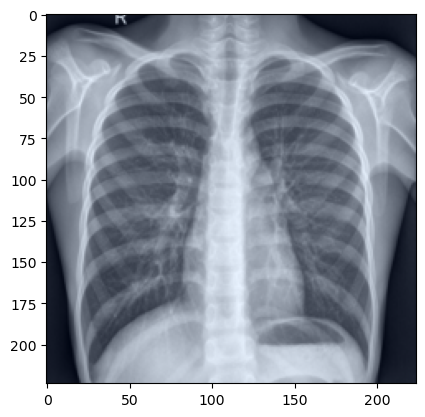

Actual labels: NORMAL
Predicted:  N O R M A L


In [59]:
_, predicted = torch.max(outputs, 1, keepdim=True)
imshow(test_image)
print(f"Actual labels: {idx_to_class[ground_truth]}")
print('Predicted: ', ' '.join(f'{idx_to_class[predicted.item()]}'))

In [60]:
# execution of this cell takes a while, so please be patient
occlusion = Occlusion(resnet_model)
pred_label_idx = predicted.item()
attributions_occ = occlusion.attribute(
    test_image_with_batch.to(device),
    strides = (3, 8, 8),
    target=pred_label_idx,
    sliding_window_shapes=(3, 15, 15),
    baselines=0
)

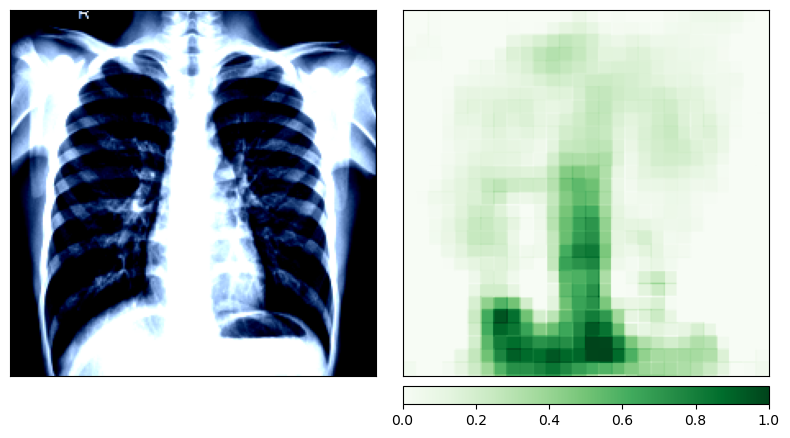

In [61]:
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(test_image_with_batch.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2
)

Perhaps we can do better. Let us try something more exquisite. The method of [**Integrated Gradients**](https://arxiv.org/abs/1703.01365). Again, please have a look at the paper.

In [62]:
# execution of this cell takes a while, so please be patient
integrated_gradients = IntegratedGradients(resnet_model)
attributions_ig = integrated_gradients.attribute(test_image_with_batch.to(device), target=pred_label_idx, n_steps=200)

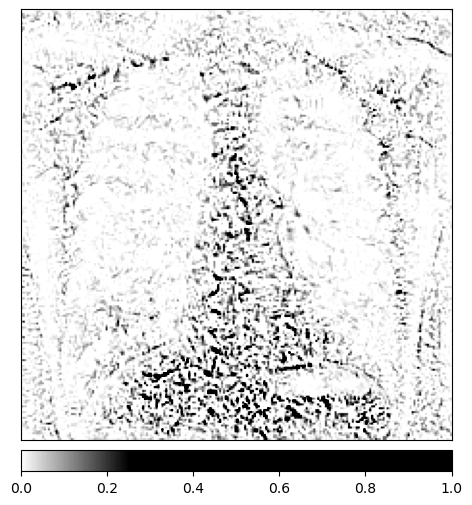

In [63]:
default_cmap = LinearSegmentedColormap.from_list(
    'custom blue',
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')],
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2 ,0)),
    np.transpose(test_image_with_batch.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

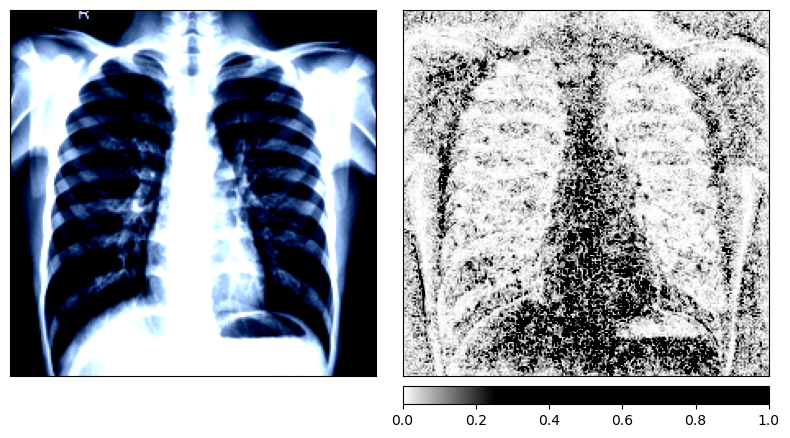

In [64]:
# execution of this cell takes a while, so please be patient
gradient_shap = GradientShap(resnet_model)

# defining baseline distribution of images
rand_img_dist = torch.cat([test_image_with_batch * 0, test_image_with_batch * 1])

attributions_gs = gradient_shap.attribute(
    test_image_with_batch.to(device),
    n_samples=50,
    stdevs=0.0001,
    baselines=rand_img_dist.to(device),
    target=pred_label_idx
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(test_image_with_batch.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "absolute_value"],
    cmap=default_cmap,
    show_colorbar=True
)

As a part of the medical community, we spend a lot of time segmenting images. Now that we have seen all the different variations, let us move to the holy grail of all, [**Grad-CAM**](https://arxiv.org/abs/1610.02391). Please familiarize yourself with Grad-CAM,

Here, we have the pure PyTorch code version for GradCAM. It is sometimes nice to check what is actually happening underneath all these external `attribution` libraries. GradCAM is perhaps the best candidate for this extensive exercise.

In [65]:
%%capture
from scipy.ndimage.interpolation import zoom
import matplotlib.cm as mpl_color_map
from PIL import Image

In [66]:
class GradCamCompatibleModel(nn.Module):
  def __init__(self, feature_extraction, classification):
    super(GradCamCompatibleModel, self).__init__()
    self.feature_extractor = nn.Sequential(*feature_extraction)
    self.flatten_tensor = nn.Flatten()
    self.classifier = classification

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.flatten_tensor(x)
    x = self.classifier(x)
    return x

In [67]:
resnet_feature_extraction_modules = list(resnet_model.children())[:-1]
final_classification_module = list(resnet_model.children())[-1]

In [68]:
%%capture
model = GradCamCompatibleModel(resnet_feature_extraction_modules, final_classification_module)
model.to(device)

In [69]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.feature_extractor._modules.items():
            x = module(x)  # forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                print("saving gradients")
                conv_output = x  # save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = self.model.flatten_tensor(x)
        x = self.model.classifier(x)
        return conv_output, x

In [70]:
class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class):
        # full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 2)
        conv_output, model_output = self.extractor.forward_pass(input_image)

        # target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().to(input_image.device)
        one_hot_output[0][target_class] = 1
        # zero grads
        self.model.feature_extractor.zero_grad()
        self.model.classifier.zero_grad()
        # backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        # get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # take averages for each gradient
        # create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)

        # multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # normalize between 0-1
        cam = np.uint8(cam * 255)  # scale between 0-255 to visualize
        cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam

In [71]:
grad_cam = GradCam(model, target_layer=2)

# generate cam mask
cam = grad_cam.generate_cam(test_image_with_batch.to(device), target_class=pred_label_idx)

saving gradients


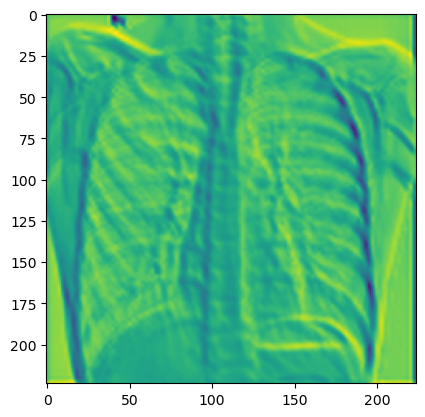

In [72]:
plt.imshow(cam)

In [73]:
%%capture
! pip install opencv-python

import cv2
heatmap_img = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

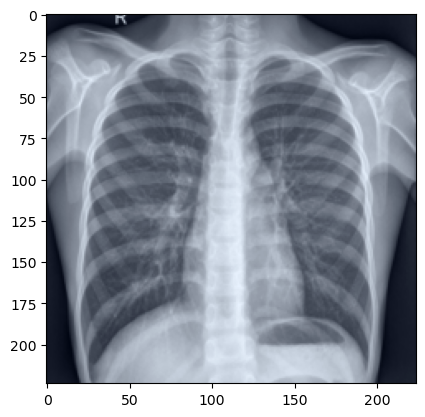

In [74]:
samp = test_image.permute(1, 2, 0).numpy()
samp = (samp - np.min(samp)) / (np.max(samp) - np.min(samp))  # normalize between 0-1
samp = np.uint8(samp * 255)
plt.imshow(samp)

In [75]:
super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, samp, 0.5, 0)

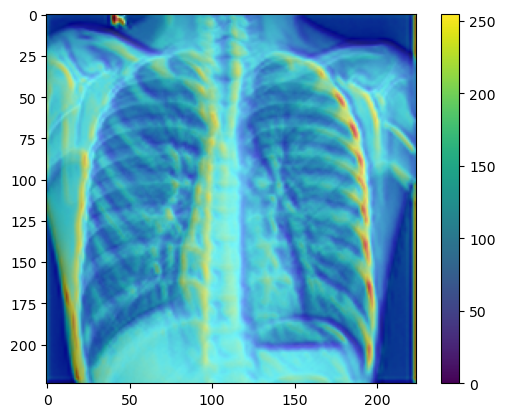

In [76]:
plt.imshow(super_imposed_img)
plt.colorbar()
plt.show()